In [5]:
pwd

'/Users/roeepartoush/Documents/Research/Code/LEanalyze'



=== Loading Fits Files... ===

***FitsDiff*** iter. no 0
/Users/roeepartoush/Documents/Research/Data/swarp_test/tycA1/20130109/tyc4419_tyc4519_20130109_coadd.fits

***ERROR:*** [Errno 2] No such file or directory: '/Users/roeepartoush/Documents/Research/Data/swarp_test/tycA1/20130109/tyc4419_tyc4519_20130109_coadd.mask.fits'
0

***FitsParams*** iter. no 0

***ERROR:*** "Keyword 'IMNAME' not found."

***ERROR:*** "Keyword 'TARGET' not found."

Image & Template .dcmp not found. Sorry!

====DONE.====


=== Extracting Flux Profiles... ===
maxFWHM=0.0004625025749999999


  0%|          | 0/6 [00:00<?, ?it/s]

0



  0%|          | 0/1 [00:00<?, ?it/s]/Users/roeepartoush/Documents/Research/Code/LEanalyze/LEtoolbox.py:185: RuntimeWarning: invalid value encountered in log10
  flux_mag = -2.5*np.log10(flux) + FP_df.iloc[indD]['ZPTMAG']

 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]

1



 33%|███▎      | 2/6 [00:01<00:02,  1.61it/s]

2



 50%|█████     | 3/6 [00:01<00:01,  2.00it/s]

3



 67%|██████▋   | 4/6 [00:02<00:00,  2.26it/s]

4



 83%|████████▎ | 5/6 [00:02<00:00,  2.43it/s]

5



100%|██████████| 6/6 [00:02<00:00,  2.16it/s]




=== Plotting Images... ===


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


dust_width, PeakFlux, arcs_shift, phs_grad, add_const = [2.159915788115544, 55.900634708827276, -0.739976881317828, 16.0, -3.0724901786846885, 1.6650092699999997]
Total width: 43.635 [days] <--> 2.727 [arcsec]
PSF width: 26.640 [days]  <--> 1.665 [arcsec]
Dust width: 34.559 [days]  <--> 2.160 [arcsec]

28.183436470033158
0.5043808930372504
28.195212055787387
dust_width, PeakFlux, arcs_shift, phs_grad, add_const = [1.2626088591797857, 39.426594331510024, -0.7869159073415206, 16.0, -0.36326355398296073, 1.6650092699999997]
Total width: 33.434 [days] <--> 2.090 [arcsec]
PSF width: 26.640 [days]  <--> 1.665 [arcsec]
Dust width: 20.202 [days]  <--> 1.263 [arcsec]

22.898729467734164
0.5810780834237104
22.909929870077967
dust_width, PeakFlux, arcs_shift, phs_grad, add_const = [1.2626469687602326, 32.79825714999313, -1.0374545197252747, 16.0, 0.11953305335049436, 1.6650092699999997]
Total width: 33.434 [days] <--> 2.090 [arcsec]
PSF width: 26.640 [days]  <--> 1.665 [arcsec]
Dust width: 20.202

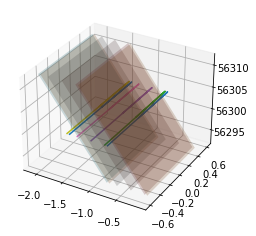

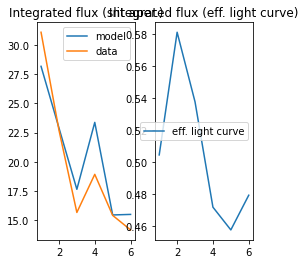

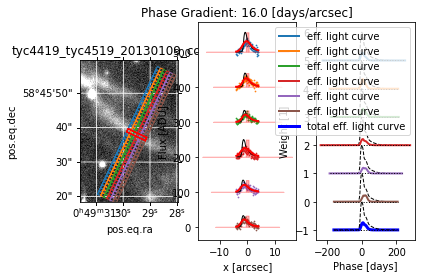

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 20 11:30:02 2021

@author: roeepartoush
"""


# ====================
# ==== SETUP CELL ====
# ====================


# ========== IMPORT PACKAGES ==========

# base imports
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'widget')
#%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
from copy import deepcopy

# astropy imports
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.time import Time
from astropy import wcs
from astropy.visualization import ZScaleInterval

# local modules
import File2Data as F2D
import DustFit as DFit
import LEtoolbox as LEtb
import LEplots

from lmfit import Model
import lmfit

import run_global_vars


import sys
sys.path.append('../../')
# !cd ../

# ========== LOAD LIGHT CURVES ==========
LChome_dir = '/Users/roeepartoush/Documents/Research/Data/light_curves'
LCs_file = LChome_dir + '/SNIa_model_mlcs2k2_v007_early_smix_z0_av0_desr_ab.txt'
run_global_vars.LCtable = F2D.LightCurves(LCs_file)


# ======== FITTING FUNCTION DEFINITION ========

def LCgrid_eval(LCfunc,phs_wid,phs_res,phases_p):
    FWHMoSIG = 2*np.sqrt(2*np.log(2))
    
    phs_sigma = phs_wid/FWHMoSIG
    max_ph = np.nanmax(phases_p)+phs_sigma*3
    min_ph = np.nanmin(phases_p)-phs_sigma*3
    
    x_p = np.linspace(min_ph,max_ph,np.ceil((max_ph-min_ph)/phs_res).astype(int)+1)
    res = np.nanmean(np.diff(x_p))
    y_p_unscaled = gaussian_filter(LCfunc(x_p), sigma=phs_sigma/res, mode='constant', cval=0)
    
    return y_p_unscaled, x_p

dm15 = 1.0
SN_f = run_global_vars.LCtable['func_L'][run_global_vars.LCtable['dm15']==dm15][0]

def impulse(t):
    return (np.abs(t)<0.5)*10.0

run_global_vars.light_curve_fn = SN_f

# phs_res = 0.1
def ConvLC(phase, phs_wid, PeakFlux, add_const, phs_res):
    phs_min = np.max([np.nanmin(phase),-1e3])
    phs_max = np.min([np.nanmax(phase),4e3])
    flux_p_unscaled, phase_p = LCgrid_eval(run_global_vars.light_curve_fn,phs_wid,phs_res,np.array([phs_min,phs_max]))    
    const = PeakFlux/run_global_vars.light_curve_fn(0) # normalize maximun luminosity to PeakFlux
    phase_arr=np.array(phase)
    flux = np.interp(phase_arr, phase_p, const*flux_p_unscaled, left=0, right=0) + add_const
    return flux

arcs_res = 0.1
def LEprof_model( input_array, sig_dust,  peak_flux,   peak_loc, phs_grad,      add_const,      PSF,    ignore_PSF=False, ignore_dust=False):
    #               [arcsec],   [days],        [1],    [arcsec], [days/arcsec], [arbittrary],  [arcsec] 
    # ignore_PSF=False, ignore_dust=False - dummy parameters for API compatibility
    x = input_array
    phases = phs_grad*(x-peak_loc)
    
    if ignore_dust:
        sig_dust=0.0
    if ignore_PSF:
        PSF=0.0
    # eff_phs_wid = np.hypot(phs_grad*sig_dust,phs_grad*PSF)
    eff_phs_wid = np.hypot(sig_dust*phs_grad,phs_grad*PSF)
    phs_res = np.abs(arcs_res*phs_grad)
    ConvLC_params = [eff_phs_wid,peak_flux,add_const, phs_res]
    output_array = ConvLC(phases, *ConvLC_params)
    
    return output_array


def plot_local_phase_plane(ax, x_orig, ang_rad, slope, y_span, phase_span, mjd):
    y_span = np.array(y_span)
    phase_span = np.array(phase_span)
    y_msh, phs_msh = np.meshgrid(y_span,phase_span)
    x_msh = x_orig -(np.sin(ang_rad)*slope*y_span + 0*mjd+phs_msh)/(np.cos(ang_rad)*slope)
    
    # X_mesh, Y_mesh = np.meshgrid(np.linspace(x_msh.flatten().min(),x_msh.flatten().max(),10), np.linspace(y_msh.flatten().min(),y_msh.flatten().max(),10))
    
    # Z_mesh =  
    ax.plot_surface(x_msh,y_msh,mjd+phs_msh,alpha=0.2)
    return

# ======== AUXILIARY PLOTTING FUNCTIONS ========
def phase_line(phase,zero_loc,angle_rad,grad,bbox):
    x1,y1,x2,y2 = None, None, None, None
    x_min, x_max = bbox[0,0], bbox[0,1]
    y_min, y_max = bbox[1,0], bbox[1,1]
    
    x_ymin = (phase-np.sin(angle_rad)*grad*y_min)/(np.cos(angle_rad)*grad) +zero_loc
    x_ymax = (phase-np.sin(angle_rad)*grad*y_max)/(np.cos(angle_rad)*grad) +zero_loc
    x1,y1,x2,y2 = x_ymin, y_min*1.0, x_ymax, y_max*1.0
    
    if x1>x_max:
        x1 = x_max*1.0
        y1 = (phase-np.cos(angle_rad)*grad*(x1-zero_loc))/(np.sin(angle_rad)*grad)
    elif x1<x_min:
        x1 = x_min*1.0
        y1 = (phase-np.cos(angle_rad)*grad*(x1-zero_loc))/(np.sin(angle_rad)*grad)
    
    if x2>x_max:
        x2 = x_max*1.0
        y2 = (phase-np.cos(angle_rad)*grad*(x1-zero_loc))/(np.sin(angle_rad)*grad)
    elif x2<x_min:
        x2 = x_min*1.0
        y2 = (phase-np.cos(angle_rad)*grad*(x1-zero_loc))/(np.sin(angle_rad)*grad)        
    
    return x1,y1,x2,y2

def plot_proj_phaseplane(ax,zero_loc,angle_rad,grad,bbox):
    x_min, x_max = bbox[0,0], bbox[0,1]
    y_min, y_max = bbox[1,0], bbox[1,1]
    x_b = np.array([bbox[0,0],bbox[0,1],bbox[0,1],bbox[0,0],bbox[0,0]])
    y_b = np.array([bbox[1,0],bbox[1,0],bbox[1,1],bbox[1,1],bbox[1,0]])
    
    if str(type(ax))=="<class 'matplotlib.axes._subplots.Axes3DSubplot'>":
        ax.plot(x_b,y_b,np.zeros(x_b.shape),c='black',linewidth=2)
        ax.plot(np.array([x_min,x_max]),np.array([0,0]),np.array([0,0]),c='black',linewidth=1)
    
    xy_phases_b = np.cos(angle_rad)*grad*(x_b-zero_loc) +np.sin(angle_rad)*grad*y_b
    phase_min = xy_phases_b.min()
    phase_max = xy_phases_b.max()
    phase_int = 10.0
    
    N_min = np.ceil(phase_min/phase_int)
    N_max = np.floor(phase_max/phase_int)
    phases = np.arange(N_min,N_max+1)*phase_int
    for phase in phases:
        if phase==0.0:
            c='r'
        else:
            c='black'
        x1,y1,x2,y2 = phase_line(phase,zero_loc,angle_rad,grad,bbox)
        if str(type(ax))=="<class 'matplotlib.axes._subplots.Axes3DSubplot'>":
            x_l = np.array([x1,x2])
            y_l = np.array([y1,y2])
            ax.plot(x_l,y_l,np.zeros(x_l.shape),c=c,linewidth=1)
        else:
            ax.axvline(x=x1,ymin=0,ymax=200,c=c,linewidth=1)
    return


# ======== AUXILIARY FUNCTIONS ========

def coord2ofs(SC,Org,PA):
    Sep_as = Org.separation(SC).arcsec
    PA_a = Org.position_angle(SC)-PA
    x=Sep_as*np.cos(PA_a.rad)
    y=Sep_as*np.sin(PA_a.rad)
    return x,y

### STAR MASK PRINT
def coord2ofs_list(coord_list,Org,PA,verbose=False):
    sss='['
    SClst = [SkyCoord(coord,frame='fk5',unit=(u.deg, u.deg))[0] for coord in coord_list]
    xy_list = []
    for SC in SClst:
        x,y = coord2ofs(SC,Org,PA)
        psf=1.2
        xy_list.append([[x,y],psf])
        # print('x = '+str(x))
        # print('y = '+str(y)+'\n')
        sss += '[['+'{:.3f}'.format(x)+','+'{:.3f}'.format(y)+'],1.2]'
        if not (SClst.index(SC)==(len(SClst)-1)):
            sss += ', '
    sss += ']'
    if verbose:
        print(sss)
    return xy_list

def coord_corners2xy_lims(corners_unzipped,Org,PA):
    corners_SClst = [SkyCoord(coord,frame='fk5',unit=(u.deg, u.deg))[0] for coord in coord_list]
    x_lims = []
    y_lims = []
    for corner1, corner2 in zip(corners_SClst[0::2],corners_SClst[1::2]):
        x1,y1 = coord2ofs(corner1,Org,PA)
        x2,y2 = coord2ofs(corner2,Org,PA)
        x_lims.append([min(x1,x2), max(x1,x2)])
        y_lims.append([min(y1,y2), max(y1,y2)])
    return x_lims, y_lims

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xy'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xy'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# %
# ====================
# ==== PREP  CELL ====
# ====================

# ========== DEFAULT VALUES ==========
global coord_list
coord_list=[]

x_cutoff = []
y_cutoff = []
star_list = []
phs_grd_lst = []
dst_wid_lst = []
peak_flx_lst = []
peak_loc_lst = []
popt_lst = []
result_lst = []
estimate_flux_bias = False
estimate_peak = False
# ====================

# ========= USER INPUT =========
# == COPY AND PASTE OVER HERE ==
# ------------------------------

PA_DEF = 155
# == Time Series #3 ==
Orgs=SkyCoord([(12.37191576, 58.76229830)],frame='fk5',unit=(u.deg, u.deg))
Orgs=SkyCoord([Orgs[0].directional_offset_by(Angle(PA_DEF,u.deg),Angle(6.5,u.arcsec)).directional_offset_by(Angle(PA_DEF+90,u.deg),Angle(ofs,u.arcsec)) for ofs in np.linspace(-2.5,2.5,6)+1])
PA = Angle([Angle(PA_DEF,'deg') for Org in Orgs])+Angle(180,u.deg)
Ln = Angle([41  for Org in Orgs],u.arcsec)
Wd = Angle([1  for Org in Orgs],u.arcsec)

# x_cutoff = np.sort(-np.array([[-19,-10],[-13.5,-0],[3,-3],  [0,12]])).tolist()
x_cutoff = np.sort(-np.array([[4,-4]])).tolist()

root = '/Users/roeepartoush/Documents/Research/Data/swarp_test/tycA1/'
filenames = [#'20120118/tyc4419_tyc4519_20120118_coadd.fits',
             #'20120626/tyc4419_tyc4519_20120626_coadd.fits',
             #'KECK/tyc4419_1.R.r120918_0182_4.hdrfix_CORRECTED_DEG_MJD.sw._NOT_REALLY_coadd.fits',
             '20130109/tyc4419_tyc4519_20130109_coadd.fits']
img_titles = [#'KP, VR, 20120118',
              #'KP, VR, 20120626',
              #'KECK, R, 20120918',
              'KP, VR, 20130109']

phs_grd_lst = [16.0]*len(filenames)
# dst_wid_lst = [1.2]*len(filenames)
# peak_flx_lst = [100]*len(filenames)
# estimate_flux_bias = True # estimate additive constant
# estimate_peak = True # peak flux amplitude 
# # before fitting, and fix the respective parameters during fitting
# ------------------------------


clmns = ['Orig', 'PA', 'Length','WIDTH']
slitFPdf = pd.DataFrame(index=np.arange(len(Orgs)), columns=clmns, data = [(Orgs[i],PA[i],Ln[i],Wd[i]) for i in np.arange(len(Orgs))])

# ========== LOAD FITS FILES ==========
print('\n\n=== Loading Fits Files... ===')
files=[]

for file in filenames:
    files.append(os.path.join(root, file[:-5]))

DIFF_df = F2D.FitsDiff(files)

if not x_cutoff:
    x_cutoff = [[-Ln[0].arcsec/2, Ln[0].arcsec/2]]*len(DIFF_df)
if not y_cutoff:
    y_cutoff = [[-Wd[0].arcsec/2, Wd[0].arcsec/2]]*len(DIFF_df)

# ========== EXTRACT PROFILE FROM IMAGE ==========
print('\n\n=== Extracting Flux Profiles... ===')
FP_df_lst = LEtb.getFluxProfile(DIFF_df, slitFPdf, REF_image=None, N_bins=int(Ln[0].arcsec),uniform_wcs=False)


# ========== PLOT IMAGES & PROFILES ==========
print('\n\n=== Plotting Images... ===')
plt.close('all')
figures=[plt.figure() for i in DIFF_df.index]
managers=[manager for manager in plt._pylab_helpers.Gcf.get_all_fig_managers()]
# for mng in managers: mng.window.showMaximized()

# img_axs = [figures[1].add_subplot(141+ii,projection=DIFF_df.iloc[ii].WCS_w) for ii in np.arange(len(figures))]
# figures = [figures[0]]*len(figures)
# axs = LEplots.imshows(DIFF_df,plot_Fprofile=True, profDF=slitFPdf, prof_sampDF_lst=FP_df_lst, prof_crop=(x_cutoff,y_cutoff), popts=popt_lst, g_cl_arg=coord_list, FullScreen=False, figs=figures, img_axs=img_axs)
# for ii in np.arange(len(axs)): axs[ii].title.set_text(img_titles[ii])
axs = LEplots.imshows(DIFF_df,plot_Fprofile=True, profDF=slitFPdf, prof_sampDF_lst=FP_df_lst, prof_crop=None, popts=popt_lst, g_cl_arg=coord_list, FullScreen=False, figs=figures)
# axs = LEplots.imshows(DIFF_df,plot_Fprofile=True, profDF=slitFPdf, prof_sampDF_lst=FP_df_lst, prof_crop=(x_cutoff,y_cutoff), popts=popt_lst, g_cl_arg=coord_list, FullScreen=False, figs=figures)

w_s = DIFF_df['WCS_w'].to_list()
LEplots.match_zoom_wcs(axs,w_s,slitFPdf.iloc[0]['Orig'],slitFPdf.iloc[0]['Length']*0.7,slitFPdf.iloc[0]['Length']*1.0)


# ========== PLOT PROFILES 3D ==========
inds=[i for i in np.arange(len(DIFF_df))]
slit_inds = np.arange(len(Orgs)).tolist()


plot_flux_samps = False
input_arr_s_allslits, z_s_allslits = [], []
input_arr_s_uc_allslits, z_s_uc_allslits = [], []
for slit_ind in slit_inds:
    input_arr_s, z_s = [], []
    input_arr_s_uc, z_s_uc = [], []
    pa = PA[slit_ind]
    for ind in inds:
        iii=inds.index(ind)
        if plot_flux_samps:
            fig=plt.figure()
            if iii!=0 or slit_ind!=0:
                ax=fig.add_subplot(sharex=ax,sharey=ax)
            else:
                ax=fig.add_subplot()

        x=FP_df_lst[slit_ind].iloc[ind]['ProjAng'].arcsec
        y=FP_df_lst[slit_ind].iloc[ind]['PerpAng'].arcsec
        z=FP_df_lst[slit_ind].iloc[ind]['FluxProfile_ADU']
        mjd_curr = DIFF_df.iloc[ind]['Idate']
        PSF_curr = DIFF_df.iloc[ind]['FWHM_ang'].arcsec
        
        # uncropped data:
        shape = (len(x),1)
        input_arr_s_uc.append(deepcopy(np.concatenate((x.reshape(shape),y.reshape(shape),mjd_curr*np.ones(shape),PSF_curr*np.ones(shape)),axis=1)))
        z_s_uc.append(deepcopy(z.reshape(shape)))
        
        x_inds = np.logical_and(x>(x_cutoff[iii][0]), x<(x_cutoff[iii][1]))
        x = x[x_inds]
        y = y[x_inds]
        z = z[x_inds]
        
        y_inds = np.logical_and(y>y_cutoff[iii][0], y<y_cutoff[iii][1])
        x = x[y_inds]
        y = y[y_inds]
        z = z[y_inds]
        
        if star_list:
            star_masks = coord2ofs_list(star_list,Orgs[slit_ind],PA[slit_ind],verbose=False)
            for star_mask in star_masks:
                st_mk_inds = np.hypot((x-star_mask[0][0])*1.0,y-star_mask[0][1])>(0.5)#3.0*PSF_curr)
                # st_mk_inds = np.hypot(x-star_mask[0][0],y-star_mask[0][1])>(1.2*PSF_curr)
                x = x[st_mk_inds]
                y = y[st_mk_inds]
                z = z[st_mk_inds]
        
        # == SLIT WIDTH CORRECTION ==
        # x = x - np.tan((pa-PA[0]).rad)*y # EXPERIMENTAL - slit width effect cancellation
        # x_SCALED = x*np.cos(PA[slit_ind].rad-PA[0].rad)
        # x_inds = np.logical_and(x_SCALED>(-0.0), x_SCALED<(4.0))
        # x = x[x_inds]
        # y = y[x_inds]
        # z = z[x_inds]
        # x = x*np.cos(PA[slit_ind].rad-PA[0].rad)
        
        shape = (len(x),1)
        input_arr_s.append(np.concatenate((x.reshape(shape),y.reshape(shape),mjd_curr*np.ones(shape),PSF_curr*np.ones(shape)),axis=1))
        z_s.append(z.reshape(shape))
    
    
    input_arr_s_allslits.append(input_arr_s)
    z_s_allslits.append(z_s)
    input_arr_s_uc_allslits.append(input_arr_s_uc)
    z_s_uc_allslits.append(z_s_uc)
    
popt_lst_BU = deepcopy(popt_lst)
result_lst_BU = deepcopy(result_lst)
result_lst_slits = []
phs_grd_lst_BU = deepcopy(phs_grd_lst)
dst_wid_lst_BU = deepcopy(dst_wid_lst)
peak_loc_lst_BU = deepcopy(peak_loc_lst)
peak_flx_lst_BU = deepcopy(peak_flx_lst)
# ========== Independent Light Curve ==========
# ============== FITTING & PLOTS ==============
bnd = ([0.0,       0.0,        -16,        1,         -500,      -np.inf],
        [20.0,     1e3,        16,         60,         5e3,       np.inf])
#      sig_dust,  peak_flux,   peak_loc,   phs_grad,    add_const,      PSF
#      [days],        [1],    [arcsec],  [days/arcsec], [arbittrary],  [arcsec] 
bnds=[bnd]*len(DIFF_df)*len(slit_inds)
# result_lst_BU = []
# result_lst = []

F_SCALE=100
# plt.figure()
# ax2 = plt.subplot() 
fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
CLs = np.zeros((len(input_arr_s),3,3))
popt_lst=[]
errs_lst=[]
phs_grads=[]

pcov_lst=[]
pcorr_lst=[]

LE_model = Model(LEprof_model)
# LE_model = Model(LEprof_model_quick)
# LE_model = Model(LEprof_model_truPeak)


# def slit_win(x_arcsec,profDF,slitDF):
#     # evaluate weight function at x_arcsec on the profDF.PA axis, inside slitDF
#     # profDF and slitDF are pandas.Series objects! (single profile and single slit)
    
#     diff_angle = profDF.PA - slitDF.PA
#     # if profDF.PA - slitDF.PA IS 0/90 DEG:
#     #     return SIMPLE CASE
#     # def y_top(x):
#     #     slope = np.tan(angle.rad)
#     #     return y
#     x_slit_cntr, y_slit_cntr = coord2ofs(slitDF.Orig,profDF.Orig,profDF.PA)
#     kernel_win = (np.abs(x_arcsec-x_slit_cntr) < slitDF.WIDTH.arcsec/np.sin(diff_angle.rad)/2)*1.0
#     slit_anchors = np.abs(x_arcsec)
#     np.sin(diff_angle.rad)
#     (np.abs(x_arcsec)<(sltltDF.WIDTH[0].arcsec/np.cos((slitltDF.PA[0]-phs_grd_angle).rad)/2))*1.0
#     return slit_win

fig_integrals = plt.figure(10)
FP_int_lst = []
FP_DATA_int_lst = []
ELC_int_lst = []

eff_LC_funs = []
for slit_ind in slit_inds:
    input_arr_s, z_s = input_arr_s_allslits[slit_ind], z_s_allslits[slit_ind]
    input_arr_s_uc, z_s_uc = input_arr_s_uc_allslits[slit_ind], z_s_uc_allslits[slit_ind]
    FP = FP_df_lst[slit_ind]
    # for i in np.arange(len(input_arr_s)):
    for i in inds:
        z = deepcopy(z_s[i].flatten())
        inp_arr = deepcopy(input_arr_s[i])
        z_uc = deepcopy(z_s_uc[i].flatten())
        inp_arr_uc = deepcopy(input_arr_s_uc[i])
        x_uc, y_uc = inp_arr_uc[:,0], inp_arr_uc[:,1]
        
        x_FP_bin = FP.iloc[i].FP_Ac_bin_x
        z_FP_bin = FP.iloc[i].FP_Ac_bin_y
            
        x, y, PSF = inp_arr[:,0], inp_arr[:,1], inp_arr[0,3]
        x_argsort=x.argsort()
        x_sorted = x[x_argsort]
        inp_arr_sorted = inp_arr[x_argsort]
        z_sorted = z[x_argsort]
        x_span = x.max()-x.min()
        
        x_bnd = (inp_arr[:,0].min(),inp_arr[:,0].max())
        mjd = inp_arr[:,2][0]
        bnd_tmp = deepcopy(bnds[i])
        bnd_tmp[0][2] = x_bnd[0]
        bnd_tmp[1][2] = x_bnd[1]
        
        paramss = LE_model.make_params()
        for ii in np.arange(len(paramss)):
            p = paramss[list(paramss)[ii]]
            p.min=bnd_tmp[0][ii]
            p.max=bnd_tmp[1][ii]
            p.value = (p.min+p.max)/2
        
        
        
        if estimate_flux_bias:
            args = (x.max()-x)<(x_span/10)
            bias_est = np.mean(z[args])
            paramss['add_const'].value = bias_est # estimate flux bias
            # paramss['add_const'].vary = False # fix flux bias
            
            if estimate_peak:
                light_curve_IPR = 35
                # intg_est = np.trapz(z_sorted-bias_est,x_sorted)
                # paramss['add_const'].min = z.min()
                # paramss['add_const'].max = intg_est/x_span
                # paramss['add_const'].value = (paramss['add_const'].max+paramss['add_const'].min)/2
                # intg_est = np.trapz(z_sorted-bias_est,x_sorted)
                # paramss['peak_flux'].expr = str('{:.3f}'.format(intg_est)+'*abs(phs_grad)/'+'{:.3f}'.format(light_curve_IPR)) # estimate peak flux
                
                
                paramss._asteval.symtable['x_sorted'] = x_sorted
                paramss._asteval.symtable['z_sorted'] = z_sorted
                paramss['peak_flux'].value = np.trapz(z_sorted-bias_est,x_sorted)*np.abs(phs_grad)/(light_curve_IPR)
                # paramss['peak_flux'].expr = str('trapz(z_sorted-add_const,x_sorted)'+'*abs(phs_grad)/'+'{:.3f}'.format(light_curve_IPR)) # estimate peak flux
        
        if peak_flx_lst_BU:
            if peak_flx_lst_BU[i]:
                peak_flx = deepcopy(peak_flx_lst_BU[i])
                paramss['peak_flux'].value = peak_flx # fix phase gradient
                paramss['peak_flux'].vary = False # fix phase gradient
        
        if phs_grd_lst_BU:
            if phs_grd_lst_BU[i]:
                phs_grd = deepcopy(phs_grd_lst_BU[i])
                paramss['phs_grad'].value = phs_grd # fix phase gradient
                paramss['phs_grad'].vary = False # fix phase gradient
        
        if dst_wid_lst_BU:
            if dst_wid_lst_BU[i]:
                phs_grd = deepcopy(dst_wid_lst_BU[i])
                paramss['sig_dust'].value = phs_grd # fix phase gradient
                paramss['sig_dust'].vary = False # fix phase gradient
        
        if peak_loc_lst_BU:
            peak_loc = deepcopy(peak_loc_lst_BU[i])
            paramss['peak_loc'].value = peak_loc # fix peak location
            paramss['peak_loc'].vary = False # fix peak location
        
        # paramss['sig_dust'].value = 1.19
        # paramss['sig_dust'].vary = False
        
        paramss['PSF'].value = PSF
        paramss['PSF'].vary = False
        
        # == FITTING == 
        args = (x.max()-x)<(x_span/10)
        data_std_est = np.std(z[args])
        z_stds = np.ones(z.shape)*1.0*data_std_est
        if result_lst_BU:
            result = deepcopy(result_lst[i])
        else:
            result=LE_model.fit(z,params=paramss,input_array=x, weights=1.0/z_stds)
            result_lst.append(deepcopy(result))
        popt = []
        for ii in np.arange(len(paramss)):
            p = result.params[list(paramss)[ii]]
            popt.append(p.value)
        pcov = deepcopy(result.covar)
        # ============
        
        popt_lst.append(popt.copy())
        pcov_lst.append(deepcopy(pcov))

        print('dust_width, PeakFlux, arcs_shift, phs_grad, add_const = '+str(popt))
        sig_dust,peak_flux,peak_loc,p05,phs_grad, add_const = popt[0], popt[1], popt[2], 0, popt[3], popt[4]
        phs_grads.append(np.array(phs_grad).copy())
        grad = phs_grad # day/arcsec
        dust_wid = popt[0] # days # NEW: [arcsec] (July 2021)
        total_width_arcsec = np.hypot(dust_wid,PSF)
        print('Total width: '+'{:.3f}'.format(total_width_arcsec*np.abs(grad))+' [days] <--> '+'{:.3f}'.format(total_width_arcsec)+' [arcsec]')
        print('PSF width: '+'{:.3f}'.format(np.abs(grad)*PSF)+' [days]  <--> '+'{:.3f}'.format(PSF)+' [arcsec]')
        print('Dust width: '+'{:.3f}'.format(np.abs(grad)*dust_wid)+' [days]  <--> '+'{:.3f}'.format(dust_wid)+' [arcsec]\n')
        # print(np.sqrt(np.diag(pcov)))
        
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        fig=figures[i]
        plt.figure(fig.number);
        if len(fig.get_axes())<2:
            ax = plt.subplot2grid((3,3),(0,1),rowspan=3,colspan=1)
        else:
            ax = fig.get_axes()[1]
        # if i!=0:
        #     # ax=fig.add_subplot(222)#,sharex=ax)
        #     ax = plt.subplot2grid((3,3),(0,1),rowspan=1,colspan=2)
        #     # ax=fig.add_subplot(224,projection='3d',sharex=ax,sharey=ax)
        # else:
        #     # ax=fig.add_subplot(222)
        #     ax = plt.subplot2grid((3,3),(0,1),rowspan=1,colspan=2)
        #     # ax=fig.add_subplot(224,projection='3d')
        
        const_offs = 100*(len(slit_inds)-1-slit_ind)
        # # x, y = inp_arr[:,0], inp_arr[:,1]
        # # xy_phases = peak_loc +np.cos(p05)*phs_grad*x +np.sin(p05)*phs_grad*y +mjd
        # # ax.scatter(x,y,xy_phases,c='b',s=1)
        bbox=np.array([[x.min(),x.max()],[y.min(),y.max()]])
        # plot_proj_phaseplane(ax,peak_loc,p05,grad,bbox)
        
        x_scaling = 1.0#np.cos(PA[slit_ind].rad-PA[0].rad)
        # # ax.plot(x_sorted,LEprof_model(x_sorted,0.0,peak_flux,peak_loc,phs_grad, add_const, 0.0),c='k',linewidth=0.5,label='clean light curve')
        # # ax.plot(x_sorted,LEprof_model(x_sorted,0.0,peak_flux,peak_loc,phs_grad, add_const, PSF),c='b',linewidth=0.5,label='PSF only')
        ax.plot(x_sorted,LEprof_model(x_sorted,*popt,ignore_dust=True,ignore_PSF=True)+const_offs-result.params['add_const'],c='k',linewidth=1,label='light curve')
        # ax.plot(x_sorted,LEprof_model(x_sorted,*popt,ignore_dust=True),c='b',linewidth=0.5,label='PSF only')
        ax.plot(x_sorted*x_scaling,LEprof_model(x_sorted,*popt)+const_offs-result.params['add_const'],c='r',linewidth=2,label='fit (PSF+dust)')
        # ax.axhline(y=add_const*0+data_std_est,c='c')
        # ax.axhline(y=add_const*0-data_std_est,c='c')
        # ax.axvline(x=peak_loc,c='r')
        
        # ax.plot(x_sorted,z_sorted,linewidth=0.2,label='data')
        # ax.scatter(x,LEprof_model(inp_arr_zeroPSF,0,peak_flux,peak_loc,phs_grad, add_const),c='k',s=0.2,label='zero PSF & zero dust width')
        # ax.scatter(x,LEprof_model(inp_arr,0,peak_flux,peak_loc,phs_grad, add_const),c='b',s=0.2,label='zero dust width')
        # ax.scatter(x,LEprof_model(inp_arr,*popt),c='r',s=1,label='fit')
        ax.scatter(x*x_scaling,z+const_offs,s=0.5, label='data')
        # ax.plot(x_FP_bin*x_scaling,z_FP_bin+const_offs, label='binned')
        # ax.errorbar(x,z,yerr=z_stds,fmt='.',label='data')
        # ax.scatter(x_uc,z_uc,c='k',s=0.3, label='')
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        # place a text box in upper left in axes coords
        # ax.text(0.05, 0.95, result.fit_report(), transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=props)
        
        # im=ax.scatter(x,y,cmap='jet',c=z-LEprof_model(inp_arr,*popt),s=1)
        # fig.colorbar(im,ax=ax,orientation="horizontal")
        ax.set_xlabel('x [arcsec]')
        ax.set_ylabel('Flux [ADU]')
        ax.set_title('Phase Gradient: '+'{:.1f}'.format(grad)+' [days/arcsec]')
        # ax.set_title('MJD: '+'{:.0f}'.format(mjd))
        
        if str(type(ax))=="<class 'matplotlib.axes._subplots.Axes3DSubplot'>":
            axisEqual3D(ax)
        
        # ax2.scatter(peak_loc/phs_grad,mjd)
        # zero intersect: cos(p05)*phs_grad*X + sin(p05)*phs_grad*Y + peak_loc +mjd = 0 --> X = -(sin(p05)*phs_grad*Y + peak_loc +mjd)/cos(p05)*phs_grad
        zero_y = np.array([-0.5,0.5,0])*Wd[0].arcsec*1.2
        zero_x = peak_loc -(np.sin(p05)*phs_grad*zero_y + 0*mjd)/(np.cos(p05)*phs_grad)
        # zero_x = -(np.sin(p05)*phs_grad*zero_y + peak_loc+0*mjd)/(np.cos(p05)*phs_grad)
        ax3.plot(zero_x,zero_y,mjd)
        
        plot_local_phase_plane(ax3, peak_loc, p05, phs_grad, [-0.5,0.5], [-10,0,10], mjd)
        
        CLs[i,0,0], CLs[i,1,0], CLs[i,2,0] = zero_x
        CLs[i,0,1], CLs[i,1,1], CLs[i,2,1] = zero_y
        CLs[i,0,2], CLs[i,1,2], CLs[i,2,2] = mjd*np.ones(len(zero_y))
        
        # ax.legend()
        
        ax_img = axs[i]
        prof_orig = slitFPdf['Orig'][0]
        prof_PA_x = slitFPdf['PA'][0]
        prof_PA_y = slitFPdf['PA'][0] + Angle(90,u.deg)
        prof_width = slitFPdf['WIDTH'][0]
        
        peak_arcsec_shift = Angle(popt[2],u.arcsec)
        corner1 = prof_orig.directional_offset_by(prof_PA_x,peak_arcsec_shift).directional_offset_by(prof_PA_y,-prof_width/2)
        corner2 = prof_orig.directional_offset_by(prof_PA_x,peak_arcsec_shift).directional_offset_by(prof_PA_y, prof_width/2)
        xy = np.array([[corner1.ra.degree, corner1.dec.degree], [corner2.ra.degree, corner2.dec.degree]])
        # ax_img.plot(xy[:,0], xy[:,1], transform = ax_img.get_transform('world'), linewidth=0.5, color='r')
        
        # === July 30 2021 ===
        # ax_phs = ax.twiny()
        # xlims_arcsec = np.array(ax.get_xlim())
        # ax_phs.set_xlim((xlims_arcsec-peak_loc)*grad)
        # if np.sign(grad)<0: ax_phs.invert_xaxis()
        
        # == SLITLET ==
        FWHMoSIG = 2*np.sqrt(2*np.log(2))
        
        # Orgs=SkyCoord([(12.37191576, 58.76229830)],frame='fk5',unit=(u.deg, u.deg))
        # PA = Angle([Angle(150-90-10,'deg') for Org in Orgs])+Angle(180,u.deg)
        # Ln = Angle([10  for Org in Orgs],u.arcsec)
        # Wd = Angle([1  for Org in Orgs],u.arcsec)
        # clmns = ['Orig', 'PA', 'Length','WIDTH']
        # slitFPdf = pd.DataFrame(index=np.arange(len(Orgs)), columns=clmns+['cntr_arcsec','length_arcsec'], data = [np.array([[0*peak_loc,2]])]+[(Orgs[i],PA[i],Ln[i],Wd[i]) for i in np.arange(len(Orgs))])
        sltltDF = pd.DataFrame(columns=['cntr_arcsec','length_arcsec'],data=np.array([[0*peak_loc,1]]))
        
        phs_grd_angle = slitFPdf.PA[0]
        
        # sltltDF = pd.DataFrame(columns=['cntr_arcsec','length_arcsec'],data=np.array([[0*peak_loc,2]]))
        x_arcsec = np.linspace(x.min()-total_width_arcsec*4,x.max()+total_width_arcsec*4,500) # [arcsec]
        x_days = (x_arcsec-peak_loc)*grad
        arcsec_res = np.mean(np.diff(x_arcsec))
        
        # slitwid_proj_win = 
        slit_win = np.abs(np.abs(x_arcsec-sltltDF.cntr_arcsec[0])<sltltDF.length_arcsec[0]/2)*1.0
        slit_win_DATA = np.abs(np.abs(x_sorted-sltltDF.cntr_arcsec[0])<sltltDF.length_arcsec[0]/2)*1.0
        # slit_win = (np.abs(x_arcsec)<(sltltDF.WIDTH[0].arcsec/np.cos((slitltDF.PA[0]-phs_grd_angle).rad)/2))*1.0
        FP_int_lst.append(np.trapz(slit_win*(LEprof_model(x_arcsec,*popt)-result.params['add_const']),x_arcsec))
        FP_DATA_int_lst.append(np.trapz(slit_win_DATA*(z_sorted-result.params['add_const']),x_sorted))
        print(np.trapz(slit_win*(LEprof_model(x_arcsec,*popt)-result.params['add_const']),x_arcsec))
        
        # sltltDF.PA
        # slit_orientation_win = ()*1.0
        conv_win = ndimage.gaussian_filter(slit_win,sigma=(total_width_arcsec/FWHMoSIG)/arcsec_res)
        # conv_win = conv_win/conv_win.max()
        
        delta_win = np.abs(np.abs(x_arcsec-sltltDF.cntr_arcsec[0])<np.diff(x_arcsec).min())*1.0
        conv_ker = ndimage.gaussian_filter(delta_win,sigma=(total_width_arcsec/FWHMoSIG)/arcsec_res)
        conv_ker = conv_ker/conv_ker.max()
        
        clean_LC = SN_f((x_arcsec-peak_loc)*grad)/SN_f(0)
        eff_LC = clean_LC*conv_win
        ELC_int_lst.append(np.trapz(eff_LC,x_arcsec))
        # ELC_int_lst.append(np.trapz(eff_LC*popt[1],x_arcsec))
        print(np.trapz(slit_win*ndimage.gaussian_filter(clean_LC,sigma=(total_width_arcsec/FWHMoSIG)/arcsec_res),x_arcsec))
        print(np.trapz(eff_LC*popt[1],x_arcsec))
        
        # plt.figure(slit_ind*20)        
        # plt.plot(x_arcsec,clean_LC,label='clean_LC')
        # plt.plot(x_arcsec,ndimage.gaussian_filter(clean_LC,sigma=(total_width_arcsec/FWHMoSIG)/arcsec_res),label='conv_LC')        
        # plt.plot(x_arcsec,conv_win,label='conv_win')        
        # plt.plot(x_arcsec,slit_win,label='slit_win')
        # plt.plot(x_arcsec,slit_win,label='slit_win')
        # plt.plot(x_arcsec,eff_LC,label='eff_LC')        
        # plt.plot(x_arcsec,LEprof_model(x_arcsec,*popt)/popt[1],label='modeled_LC')
        # plt.legend()
        # plt.figure(fig.number);
        # def eff_LC_fun(days):
        #     fluxs = np.interp(days,x_days,eff_LC,left=0,right=0)
        #     return fluxs
        eff_LC_funs.append(deepcopy([x_days,eff_LC,popt[1]]))
        
        # ax_wf_days = plt.subplot2grid((3,3),(0,2),rowspan=3,colspan=1)
        # ax_wf_days.plot(x_days,slit_win,':',c='k',linewidth=1,label='slitlet aperture')
        # ax_wf_days.plot(x_days,conv_ker,c='r',linewidth=1,label='conv. kernel')
        # ax_wf_days.plot(x_days,conv_win,c='b',linewidth=2,label='window function')
        # plt.ylabel('Weight [1]')
        # plt.xlabel('Phase [days]')
        # plt.legend()
        if len(fig.get_axes())<3:
            ax_wf_days = plt.subplot2grid((3,3),(0,2),rowspan=3,colspan=1)#,sharex=ax_wf_days)
        else:
            ax_wf_days = fig.get_axes()[2]  
        ax_wf_days.plot(x_days,const_offs/100+clean_LC,'--',c='k',linewidth=1,label='')
        ax_wf_days.plot(x_days,const_offs/100+eff_LC,linewidth=2,label='eff. light curve')
        ax_wf_days.plot(x_days,const_offs/100+eff_LC*0,':',c='k',linewidth=1,label='')
        
        # ax_wf_days.plot(x_days,signal.gaussian(x_days.shape[0],(total_width_arcsec/FWHMoSIG)/arcsec_res),c='m',linewidth=1,label='gaussian')
        plt.ylabel('Weight [1]')
        plt.xlabel('Phase [days]')
        plt.legend()
        
        # ax.plot(x_arcsec,slit_win,':',c='k',linewidth=1,label='slitlet aperture')
        ax.fill_between(x_arcsec,0+const_offs,const_offs+slit_win*result.params['peak_flux'].value,color='r',alpha=0.3,label='slitlet aperture')
        plt.legend()
        
        # == PLOT SLITLET ==
        sltlt_wid = slitFPdf.iloc[slit_ind].WIDTH.arcsec
        sltlt_len = sltltDF.length_arcsec[0]#Angle(sltltDF.length_arcsec[0],u.arcsec)
        sltlt_cntr = sltltDF.cntr_arcsec[0]#Angle(sltltDF.cntr_arcsec[0],u.arcsec)
        
        prof_orig = slitFPdf['Orig'][0]
        
        prof_orig = prof_orig.directional_offset_by(prof_orig.position_angle(slitFPdf['Orig'].to_list()[-1]),prof_orig.separation(slitFPdf['Orig'].to_list()[-1])/2)
        sltlt_wid = slitFPdf['Orig'][0].separation(slitFPdf['Orig'].to_list()[-1])+slitFPdf['WIDTH'][0]
        
        prof_PA_x = slitFPdf['PA'][0]
        prof_PA_y = slitFPdf['PA'][0] + Angle(90,u.deg)
        x_lims = Angle(sltlt_cntr+np.array([-0.5,0.5])*sltlt_len,u.arcsec)
        y_lims = Angle(0.0+np.array([-0.5,0.5])*sltlt_wid,u.arcsec)
        corner1 = prof_orig.directional_offset_by(prof_PA_x,x_lims[0]).directional_offset_by(prof_PA_y,y_lims[0])
        corner2 = prof_orig.directional_offset_by(prof_PA_x,x_lims[1]).directional_offset_by(prof_PA_y,y_lims[0])
        corner3 = prof_orig.directional_offset_by(prof_PA_x,x_lims[1]).directional_offset_by(prof_PA_y,y_lims[1])
        corner4 = prof_orig.directional_offset_by(prof_PA_x,x_lims[0]).directional_offset_by(prof_PA_y,y_lims[1])
        xy = np.array([[corner1.ra.degree, corner1.dec.degree], [corner2.ra.degree, corner2.dec.degree], 
                       [corner3.ra.degree, corner3.dec.degree], [corner4.ra.degree, corner4.dec.degree], [corner1.ra.degree, corner1.dec.degree]])
        ax_img.plot(xy[:,0], xy[:,1], transform = ax_img.get_transform('world'), linewidth=1, color='r')
        # ax_wf_days = ax_wf_arcsec.twiny()#sharex=ax_phs)
        # xlims_arcsec = np.array(ax_wf_arcsec.get_xlim())
        # ax_wf_days.set_xlim((xlims_arcsec-peak_loc)*grad)
        # if np.sign(grad)<0: ax_wf_days.invert_xaxis()
    result_lst_slits.append(deepcopy(result_lst[-len(slit_inds):]))

ax_FP_int = plt.subplot2grid((3,3),(0,1),rowspan=3,colspan=1,fig=fig_integrals)
ax_FP_int.plot(np.arange(len(FP_int_lst))+1,np.array(FP_int_lst),label='model')
ax_FP_int.plot(np.arange(len(FP_DATA_int_lst))+1,np.array(FP_DATA_int_lst),label='data')
ax_FP_int.title.set(text='Integrated flux (slit aper.)',wrap=True)
# plt.legend()
ax_FP_int.legend()
# ax_FP_int.set_ylim([50,80])

ax_ELC_int = plt.subplot2grid((3,3),(0,2),rowspan=3,colspan=1,fig=fig_integrals)
ax_ELC_int.plot(np.arange(len(ELC_int_lst))+1,np.array(ELC_int_lst),label='eff. light curve')
ax_ELC_int.title.set(text='Integrated flux (eff. light curve)',wrap=True)#' × modeled Peak flux',wrap=True)
# ax_ELC_int.set_ylim([50,80])
ax_ELC_int.legend()
# plt.figure(fig_integrals
# %
total_eff_LC = np.zeros(x_days.shape)
summ = 0
for tup in eff_LC_funs:
    fluxs = np.interp(x_days,tup[0],tup[1],left=0,right=0)
    total_eff_LC = total_eff_LC + fluxs*tup[2]
    summ = summ + tup[2]
total_eff_LC = total_eff_LC/summ#len(eff_LC_funs)
ax_wf_days.plot(x_days,const_offs/100-1+total_eff_LC,c='b',linewidth=3,label='total eff. light curve')
ax_wf_days.plot(x_days,const_offs/100-1+clean_LC,'--',c='k',linewidth=1,label='')
ax_wf_days.plot(x_days,const_offs/100-1+eff_LC*0,':',c='k',linewidth=1,label='')
plt.legend()
